In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import scipy.sparse

sns.set(style="whitegrid")


In [8]:
with open("../data/normalized_citations.jsonl", "r", encoding="utf-8") as f:
    norm_data = [json.loads(line) for line in f]
df_norm = pd.DataFrame(norm_data)

with open("../data/citations_with_SBERT_clusters.jsonl", "r", encoding="utf-8") as f:
    sbert_data = [json.loads(line) for line in f]
df_sbert = pd.DataFrame(sbert_data)

with open("../data/citations_with_clusters_tfidf_kmeans.jsonl", "r", encoding="utf-8") as f:
    tfidf_data = [json.loads(line) for line in f]
df_tfidf = pd.DataFrame(tfidf_data)

print(f"Normalized: {len(df_norm)} citation")
print(f"SBERT clustered: {len(df_sbert)} citation")
print(df_sbert.columns)
print(f"TF-IDF clustered: {len(df_tfidf)} citation")
print(df_tfidf.columns)


Normalized: 39296 citation
SBERT clustered: 39296 citation
Index(['ecli', 'citation', 'label', 'tags', 'id', 'normalized_fields',
       'expanded_fields', 'normalized_text', 'citation_type',
       'cluster_id_sbert'],
      dtype='object')
TF-IDF clustered: 39296 citation
Index(['ecli', 'citation', 'label', 'tags', 'id', 'normalized_fields',
       'expanded_fields', 'normalized_text', 'citation_type',
       'cluster_id_tfidf_kmeans'],
      dtype='object')


In [9]:
def describe_clusters(df, cluster_col):
    cluster_counts = df[cluster_col].value_counts()
    print(f"Total unique clusters: {cluster_counts.nunique()}")
    print(f"Total citations with cluster ID: {cluster_counts.sum()}")
    print(f"Min cluster size: {cluster_counts.min()}")
    print(f"Max cluster size: {cluster_counts.max()}")
    print(f"Mean cluster size: {cluster_counts.mean():.2f}")
    print(f"Median cluster size: {cluster_counts.median()}")
    return cluster_counts

print("SBERT Cluster Stats")
sbert_cluster_counts = describe_clusters(df_sbert, "cluster_id_sbert")

print("\nTF-IDF Cluster Stats")
tfidf_cluster_counts = describe_clusters(df_tfidf, "cluster_id_tfidf_kmeans")


SBERT Cluster Stats
Total unique clusters: 112
Total citations with cluster ID: 39296
Min cluster size: 1
Max cluster size: 3757
Mean cluster size: 10.88
Median cluster size: 2.0

TF-IDF Cluster Stats
Total unique clusters: 41
Total citations with cluster ID: 39296
Min cluster size: 1
Max cluster size: 16015
Mean cluster size: 133.66
Median cluster size: 3.0


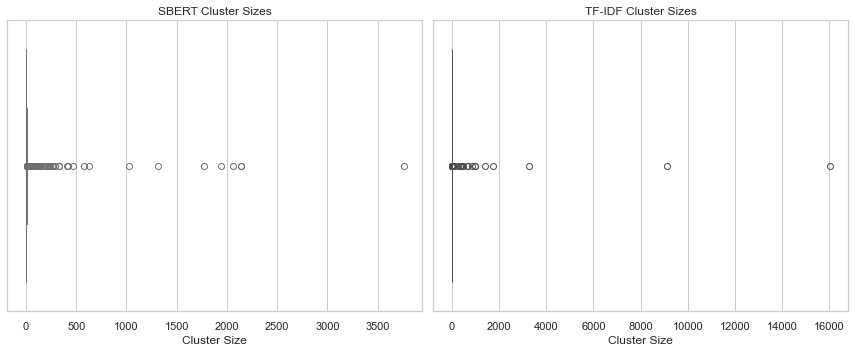

In [11]:
sbert_sizes = sbert_cluster_counts.values
tfidf_sizes = tfidf_cluster_counts.values

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=sbert_sizes, color="skyblue")
plt.title("SBERT Cluster Sizes")
plt.xlabel("Cluster Size")

plt.subplot(1, 2, 2)
sns.boxplot(x=tfidf_sizes, color="orange")
plt.title("TF-IDF Cluster Sizes")
plt.xlabel("Cluster Size")

plt.tight_layout()
plt.show()


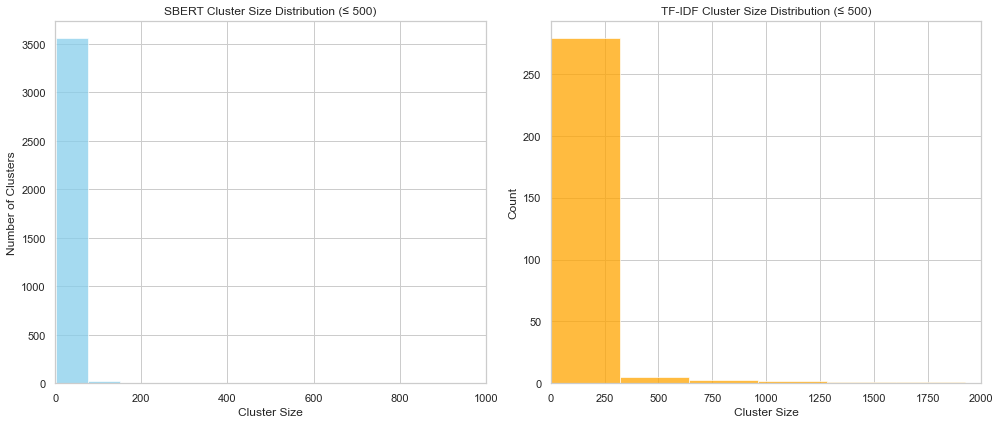

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(sbert_sizes, bins=50, color="skyblue")
plt.title("SBERT Cluster Size Distribution (≤ 500)")
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plt.xlim(0, 1000)

plt.subplot(1, 2, 2)
sns.histplot(tfidf_sizes, bins=50, color="orange")
plt.title("TF-IDF Cluster Size Distribution (≤ 500)")
plt.xlabel("Cluster Size")
plt.xlim(0, 2000)

plt.tight_layout()
plt.show()


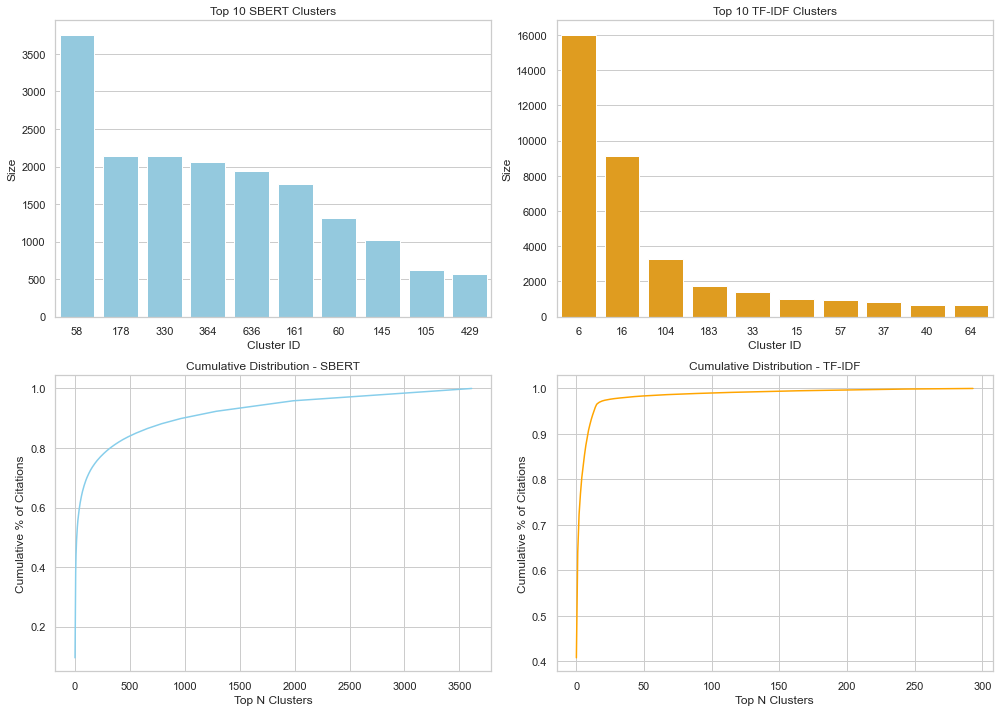

In [13]:

sbert_sizes = df_sbert["cluster_id_sbert"].value_counts()
tfidf_sizes = df_tfidf["cluster_id_tfidf_kmeans"].value_counts()

sbert_cumsum = sbert_sizes.sort_values(ascending=False).cumsum() / sbert_sizes.sum()
tfidf_cumsum = tfidf_sizes.sort_values(ascending=False).cumsum() / tfidf_sizes.sum()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(x=sbert_sizes.head(10).index.astype(str), y=sbert_sizes.head(10).values, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title("Top 10 SBERT Clusters")
axes[0, 0].set_ylabel("Size")
axes[0, 0].set_xlabel("Cluster ID")

sns.barplot(x=tfidf_sizes.head(10).index.astype(str), y=tfidf_sizes.head(10).values, ax=axes[0, 1], color="orange")
axes[0, 1].set_title("Top 10 TF-IDF Clusters")
axes[0, 1].set_ylabel("Size")
axes[0, 1].set_xlabel("Cluster ID")

axes[1, 0].plot(range(len(sbert_cumsum)), sbert_cumsum.values, color="skyblue")
axes[1, 0].set_title("Cumulative Distribution - SBERT")
axes[1, 0].set_ylabel("Cumulative % of Citations")
axes[1, 0].set_xlabel("Top N Clusters")

axes[1, 1].plot(range(len(tfidf_cumsum)), tfidf_cumsum.values, color="orange")
axes[1, 1].set_title("Cumulative Distribution - TF-IDF")
axes[1, 1].set_ylabel("Cumulative % of Citations")
axes[1, 1].set_xlabel("Top N Clusters")

plt.tight_layout()
plt.show()


In [14]:
tfidf_matrix = scipy.sparse.load_npz("../data/tfidf_vectors.npz")
sbert_matrix = np.load("../data/sbert_embeddings.npy")
tfidf_labels = np.array([c["cluster_id_tfidf_kmeans"] for c in tfidf_data])
sbert_labels = np.array([c["cluster_id_sbert"] for c in sbert_data])

def valid_points(matrix, labels):
    unique, counts = np.unique(labels, return_counts=True)
    valid_labels = set(lbl for lbl, count in zip(unique, counts) if count > 1)
    mask = np.array([lbl in valid_labels for lbl in labels])
    return matrix[mask], labels[mask]

X_tfidf, y_tfidf = valid_points(tfidf_matrix, tfidf_labels)
X_sbert, y_sbert = valid_points(sbert_matrix, sbert_labels)

print("Computing silhouette scores...")
score_tfidf = silhouette_score(X_tfidf, y_tfidf, metric="cosine")
score_sbert = silhouette_score(X_sbert, y_sbert, metric="cosine")

print(f"Silhouette Score (TF-IDF + KMeans): {score_tfidf:.4f}")
print(f"Silhouette Score (SBERT + Agglomerative): {score_sbert:.4f}")


Computing silhouette scores...
Silhouette Score (TF-IDF + KMeans): -0.0867
Silhouette Score (SBERT + Agglomerative): 0.4383


In [15]:
sbert_clusters = df_sbert["cluster_id_sbert"]
top_sbert = Counter(sbert_clusters).most_common(10)

print("Top 10 SBERT Clusters:")
for cluster_id, size in top_sbert:
    print(f"\nCluster ID: {cluster_id} ({size} citations)\n" + "-"*60)
    examples = df_sbert[df_sbert["cluster_id_sbert"] == cluster_id]["normalized_text"].tolist()
    for text in examples[:50]:  # Show up to 15 for readability
        print("•", text)
    print("-"*60)


Top 10 SBERT Clusters:

Cluster ID: 58 (3757 citations)
------------------------------------------------------------
• Bundesverwaltungsgericht, Urteil vom 1987.06.26, - 8 C 21/86 -, Entscheidungen des Bundesverwaltungsgerichts 78, 3
• Bundesverwaltungsgericht, Urteil vom 1982.10.27, - 3 C 6.82 -, Entscheidungen des Bundesverwaltungsgerichts 66, 218
• Bundesverwaltungsgericht, Urteil vom 1987.06.26
• Bundesverwaltungsgericht, Urteil vom 2003.02.06, - 5 C 15.02 -, Entscheidungen des Bundesverwaltungsgerichts 117, 364
• Bundesverwaltungsgericht, Urteil vom 2003.02.06
• Bundesverwaltungsgericht, Urteil vom 19.Januar 2009, - 10 C 52.07 -, Rdnr. 22 , 24
• Bundesverwaltungsgericht, Urteil vom 1.Juni 2011, - 10 C 25.10 -, Rdnr. 22
• Bundesverwaltungsgericht, Urteil vom 20.Februar 2013, - 10 C 23.12 -, Rdnr. 19
• Bundesverwaltungsgericht, Urteil vom 6.März 1990, - 9 C 14.89 -, Rdnr. 13
• Bundesverwaltungsgericht, Urteil vom 5.November 1991, - 9 C 118.90 -, Rdnr. 17
• Bundesverwaltungsgericht, 

In [16]:
empty_cluster = df_sbert[df_sbert["cluster_id_sbert"] == 636]
output_path = "../data/sbert_cluster_636_empty_citations.jsonl"

with open(output_path, "w", encoding="utf-8") as f:
    for _, row in empty_cluster.iterrows():
        json.dump({
            "id": row.get("id", None),
            "ecli": row.get("ecli", None),
            "citation": row.get("citation", None),
            "normalized_text": row.get("normalized_text", None),
            "tags": row.get("tags", None)  # Include token-label pairs
        }, f, ensure_ascii=False)
        f.write("\n")

print(f"Saved {len(empty_cluster)} citations from cluster 636 with tags to {output_path}")


Saved 1937 citations from cluster 636 with tags to ../data/sbert_cluster_636_empty_citations.jsonl


In [17]:
tfidf_clusters = df_tfidf["cluster_id_tfidf_kmeans"]
top_tfidf = Counter(tfidf_clusters).most_common(10)

print("Top 10 TF-IDF Clusters:")
for cluster_id, size in top_tfidf:
    print(f"\n📎 Cluster ID: {cluster_id} ({size} citations)\n" + "-"*60)
    examples = df_tfidf[df_tfidf["cluster_id_tfidf_kmeans"] == cluster_id]["normalized_text"].tolist()
    for text in examples[:50]:
        print("•", text)
    print("-"*60)


Top 10 TF-IDF Clusters:

📎 Cluster ID: 6 (16015 citations)
------------------------------------------------------------
• Bundesverwaltungsgericht, Urteil vom 1987.06.26, - 8 C 21/86 -, Entscheidungen des Bundesverwaltungsgerichts 78, 3
• Urteil vom 2000.01.26, - 2 L 236/98 -
• Bundesverwaltungsgericht, Urteil vom 1982.10.27, - 3 C 6.82 -, Entscheidungen des Bundesverwaltungsgerichts 66, 218
• Bundesverwaltungsgericht, Urteil vom 1987.06.26
• Bundesverwaltungsgericht, Urteil vom 1999.03.18, - 5 C 11.98 -, Entscheidungen der Verwaltungsgerichte in Schleswig-Holstein 49, 443
• Bundesverwaltungsgericht, Urteil vom 2003.02.06, - 5 C 15.02 -, Entscheidungen des Bundesverwaltungsgerichts 117, 364
• Bundesverwaltungsgericht, Urteil vom 2003.02.06
• Oberverwaltungsgericht Lüneburg, Urteil vom 1990.11.13, - 9 K 11/89 -, Neue Zeitschrift für Verwaltungsrecht - RR, 40, 1992
• Urteil vom 2000.08.24, - 2 L 226/98 -, NordÖR, 221, 2001
• Senatsurteil, Urteil vom 2006.03.15, - 2 LB 9/05 -
• Oberverwal

In [18]:
def cluster_purity(df, cluster_col, text_col="normalized_text", top_n=10):
    purity_scores = []
    top_clusters = Counter(df[cluster_col]).most_common(top_n)
    for cluster_id, size in top_clusters:
        sub = df[df[cluster_col] == cluster_id]
        most_common_text = sub[text_col].value_counts().iloc[0]
        purity = most_common_text / size
        purity_scores.append((cluster_id, size, round(purity, 3)))
    return pd.DataFrame(purity_scores, columns=["cluster_id", "size", "purity"])

purity_sbert = cluster_purity(df_sbert, "cluster_id_sbert")
purity_tfidf = cluster_purity(df_tfidf, "cluster_id_tfidf_kmeans")
display(purity_sbert.head(10))
display(purity_tfidf.head(10))


,cluster_id,size,purity
0,58,3757,0.026
1,178,2135,0.003
2,330,2135,0.006
3,364,2056,0.010
4,636,1937,1.000
5,161,1771,0.013
6,60,1315,0.021
7,145,1026,0.181
8,105,623,0.024
9,429,574,0.009


,cluster_id,size,purity
0,6,16015,0.005
1,16,9126,0.020
2,104,3277,0.591
3,183,1758,0.004
4,33,1416,0.015
5,15,989,0.025
6,57,967,0.011
7,37,830,0.016
8,40,672,0.037
9,64,642,0.012


In [19]:
def print_high_purity_clusters(df, cluster_col, text_col="normalized_text", top_n=5, examples_per_cluster=5):
    purity_data = []
    for cluster_id, group in df.groupby(cluster_col):
        texts = group[text_col].tolist()
        text_counts = Counter(texts)
        most_common_text, freq = text_counts.most_common(1)[0]
        purity = freq / len(texts)
        purity_data.append((cluster_id, purity, len(texts), group))
        
    purity_data.sort(key=lambda x: (-x[1], -x[2]))

    for cluster_id, purity, size, group in purity_data[:top_n]:
        print(f"\nCluster ID: {cluster_id} | Purity: {round(purity, 3)} | Size: {size}")
        print("-" * 60)
        for text in group[text_col].head(examples_per_cluster):
            print("•", text)
        print("-" * 60)

print("Top 5 High-Purity SBERT Clusters:")
print_high_purity_clusters(df_sbert, cluster_col="cluster_id_sbert")

print("\n\nTop 5 High-Purity TF-IDF Clusters:")
print_high_purity_clusters(df_tfidf, cluster_col="cluster_id_tfidf_kmeans")


Top 5 High-Purity SBERT Clusters:

Cluster ID: 636 | Purity: 1.0 | Size: 1937
------------------------------------------------------------
• 
• 
• 
• 
• 
------------------------------------------------------------

Cluster ID: 2792 | Purity: 1.0 | Size: 75
------------------------------------------------------------
• BAG
• BAG
• BAG
• BAG
• BAG
------------------------------------------------------------

Cluster ID: 1224 | Purity: 1.0 | Size: 17
------------------------------------------------------------
• ABl
• ABl
• ABl
• ABl
• ABl
------------------------------------------------------------

Cluster ID: 967 | Purity: 1.0 | Size: 12
------------------------------------------------------------
• Humantoxikologisches
• Humantoxikologisches
• Humantoxikologisches
• Humantoxikologisches
• Humantoxikologisches
------------------------------------------------------------

Cluster ID: 1593 | Purity: 1.0 | Size: 10
------------------------------------------------------------
• Bales/Baum

In [20]:
def cluster_purity(df, cluster_col, text_col="normalized_text", top_n=10):
    purity_scores = []
    top_clusters = Counter(df[cluster_col]).most_common(top_n)
    for cluster_id, size in top_clusters:
        sub = df[df[cluster_col] == cluster_id]
        most_common_text = sub[text_col].value_counts().iloc[0]
        purity = most_common_text / size
        purity_scores.append((cluster_id, size, round(purity, 3)))
    return pd.DataFrame(purity_scores, columns=["cluster_id", "size", "purity"])

purity_sbert = cluster_purity(df_sbert, "cluster_id_sbert")
purity_tfidf = cluster_purity(df_tfidf, "cluster_id_tfidf_kmeans")
display(purity_sbert.head(10))
display(purity_tfidf.head(10))


,cluster_id,size,purity
0,58,3757,0.026
1,178,2135,0.003
2,330,2135,0.006
3,364,2056,0.010
4,636,1937,1.000
5,161,1771,0.013
6,60,1315,0.021
7,145,1026,0.181
8,105,623,0.024
9,429,574,0.009


,cluster_id,size,purity
0,6,16015,0.005
1,16,9126,0.020
2,104,3277,0.591
3,183,1758,0.004
4,33,1416,0.015
5,15,989,0.025
6,57,967,0.011
7,37,830,0.016
8,40,672,0.037
9,64,642,0.012


In [21]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_sbert["normalized_text"].tolist()).toarray()

def avg_intra_distance(df, X, cluster_col):
    cluster_ids = df[cluster_col].unique()
    distances = []
    for cid in cluster_ids:
        indices = df[df[cluster_col] == cid].index
        if len(indices) < 2:
            continue
        subset = X[indices]
        dist = cosine_distances(subset)
        avg = np.mean(dist[np.triu_indices_from(dist, k=1)])
        distances.append(avg)
    return round(np.mean(distances), 4)

print("SBERT TF-IDF Intra-cluster Distance:", avg_intra_distance(df_sbert, X, "cluster_id_sbert"))
print("TF-IDF Intra-cluster Distance:", avg_intra_distance(df_tfidf, X, "cluster_id_tfidf_kmeans"))


SBERT TF-IDF Intra-cluster Distance: 0.4338
TF-IDF Intra-cluster Distance: 0.2813


In [22]:
merged = pd.merge(df_sbert, df_tfidf, on="normalized_text", suffixes=("_sbert", "_tfidf"))
same_cluster = merged["cluster_id_sbert"] == merged["cluster_id_tfidf_kmeans"]
print(f"Citations in Same Cluster (SBERT vs TF-IDF): {round(same_cluster.mean()*100, 2)}%")


Citations in Same Cluster (SBERT vs TF-IDF): 0.0%


In [23]:
def cluster_type_stats(df, cluster_col):
    stats = []
    for cid, group in df.groupby(cluster_col):
        if "citation_type" not in group.columns:
            continue
        top_type = group["citation_type"].value_counts(normalize=True).idxmax()
        purity = group["citation_type"].value_counts(normalize=True).max()
        stats.append((cid, top_type, round(purity, 3), len(group)))
    return pd.DataFrame(stats, columns=["cluster_id", "top_type", "purity", "size"])

display(cluster_type_stats(df_sbert, "cluster_id_sbert").sort_values("purity", ascending=False).head(10))
display(cluster_type_stats(df_tfidf, "cluster_id_tfidf_kmeans").sort_values("purity", ascending=False).head(10))


,cluster_id,top_type,purity,size
0,0,full,1.0,3
2369,2369,full,1.0,1
2399,2399,full,1.0,1
2400,2400,full,1.0,3
2401,2401,full,1.0,3
2402,2402,full,1.0,1
2403,2403,full,1.0,1
2404,2404,full,1.0,1
2405,2405,full,1.0,1
2406,2406,full,1.0,9


,cluster_id,top_type,purity,size
0,0,full,1.0,2
218,222,full,1.0,1
198,202,full,1.0,2
197,201,full,1.0,1
196,200,full,1.0,1
195,199,full,1.0,1
194,198,full,1.0,3
193,197,full,1.0,3
192,196,full,1.0,1
191,195,full,1.0,3
